In [1]:
from heidelberg_v02 import leaky_integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import pandas as pd

## Single neuron

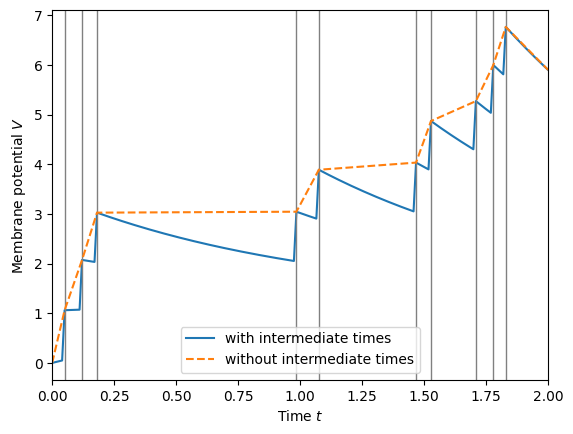

In [59]:
config = {
    "I0": 5/4,
    "tau": 1,
    "T": 2,
}

np.random.seed(0)

times = np.linspace(0, config["T"], 200)

N_sp = 10 # number of spikes
# choose N_sp random times for the spikes and store whether the neuron spiked at that time
spike_time_indices = np.random.choice(len(times), N_sp, replace=False)
spike_time_indices.sort()
spike_times = times[spike_time_indices]

spike_mask = np.zeros(len(times), dtype=bool)
spike_mask[spike_time_indices] = True

V_arr = jax.jit(leaky_integrate)(times, V_0=0, w=1, spike_mask=spike_mask, config=config)

plt.plot(times, V_arr, label="with intermediate times")
for spike_time in spike_times:
    plt.axvline(spike_time, color="gray", lw=1)

# Simulate again, but without intermediate time points
times = np.concatenate([[0], spike_times, [config["T"]]])
spike_mask = np.ones(len(times), dtype=bool)
spike_mask[0] = spike_mask[-1] = False # first and last time point are not spikes

V_arr = jax.jit(leaky_integrate)(times, V_0=0, w=1, spike_mask=spike_mask, config=config)

plt.plot(times, V_arr, linestyle="--", label="without intermediate times")

plt.xlabel("Time $t$")
plt.ylabel("Membrane potential $V$")
plt.xlim(0, config["T"])
plt.legend()
plt.show()